In [1]:
import xarray as xr
import sys
sys.path.append("../utils/")
from Interp_model2SWOT import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
def interpolate_modeltoswot(file1,
                            file2,
                            file3,
                            var_name,
                            lat_name,
                            lon_name, 
                            time_name,
                            time_step,
                            interpolator,
                            output_file
                            ):

    # Load model, mask, and SWOT data
    ds_model, ds_mask, ds_swot = read_netcdf_files(file1, file2, file3, time_name, time_step=0)
    
    # Prepare interpolation function from model data
    finterp = open_model_data(ds_model, ds_mask, interpolator, var_name ,ds_swot.latitude, ds_swot.longitude, lat_name, lon_name)
    
    # Interpolate model data to satellite swath
    output_ds = interp_satellite(ds_swot.latitude, ds_swot.longitude, ds_swot.cross_track_distance,ds_swot.quality_flag, interpolator, finterp, var="ssh")
    
    # Save to NetCDF
    output_ds.to_netcdf(output_file)
    print(f"Output saved to {output_file}")

In [3]:
def fig_interp(ds,var):
    figure, ax = plt.subplots(1,1, figsize=(6,4), 
                            subplot_kw={"projection": ccrs.PlateCarree()})

    a = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds[var],
        shading='auto',        
        cmap='RdBu_r',          
        #vmin=-0.5, vmax=0.5    
    )
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    cbar=plt.colorbar(a,extend='both')# 


In [4]:
def fig(lon,lat,ssh,model):
    ax = plt.axes([0.1, .15,   0.8, 0.6],projection=ccrs.PlateCarree())
    ax.add_feature(cf.LAND, zorder=10, edgecolor='gray')
    ax.set_global()
    
    if model in ["hycom50"]:
        a = ax.contourf(lon,lat,ssh,
            #shading='auto',        
            cmap='RdBu_r',    
            transform=ccrs.PlateCarree(),
            extend='both'
        )
        plt.colorbar(a,shrink=0.7,)
    else:
        a = ax.pcolormesh(lon,lat,ssh,
            shading='auto',        
            cmap='RdBu_r',    
            transform=ccrs.PlateCarree(),
        )
        plt.colorbar(a,extend='both',shrink=0.7,)
        
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    plt.grid()

In [5]:
# choose your model among ["enatl60", "eorca", "hycom50", "gigatl" ]

# model = input("")
model = "eorca"

In [6]:
pass_number = 497
swot_grid_file = f"../swot_grid_files/SWOT_L3_LR_SSH_Expert_008_{pass_number:03d}_20240101T000706_20240101T005832_v1.0.2.nc"
output_dir = "../interpolated_data/"

if model== "enatl60":
    file1 = "../data/eNATL60/ssh_zarr/"
    mask_file = file1
    ds=xr.open_zarr(file1)
    dsm= ds
    var_name ='sossheig'
    lat_name="nav_lat"
    lon_name="nav_lon"
    time_name= "time_counter"
    
elif model== "eorca":
    file1 = "../data/EORCA/eORCA025.L75-MLE.STD_y1967m01.nc"
    mask_file = "../data/EORCA/eORCA025.L75_byte_mask_4.2.nc"
    ds=xr.open_dataset(file1)
    dsm= xr.open_dataset(mask_file)
    var_name= "sossheig"
    lat_name= "nav_lat"
    lon_name= "nav_lon"
    time_name="time"

elif model=="hycom50":
    file1 = "../data/Hycom50/ATLc02_E037_016_032_ssh.nc"
    mask_file = "../data/Hycom50/grd_ATLc02_GS.nc"
    ds=xr.open_dataset(file1)
    dsm= xr.open_dataset(mask_file)
    var_name ='ssh'
    lat_name="plat"
    lon_name="plon"
    time_name=None

elif model=="gigatl":
    file1 = "../data/GIGATL/gigatl1_1h_tides_swot_24h_sfc_2008-03-14.nc"
    mask_file = file1
    ds=xr.open_dataset(file1)
    dsm= ds     
    var_name ='zeta'
    lat_name="lat"
    lon_name="lon"
    time_name= "time"    


In [7]:
time_step=10

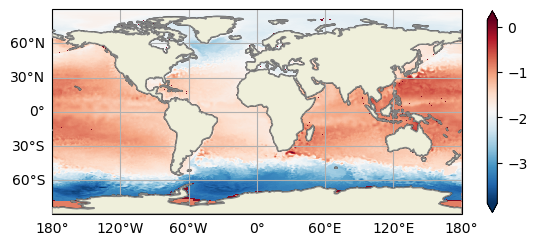

In [8]:
ds = ds.isel({time_name:time_step}) if time_name in ds.dims else ds
lon = dsm[lon_name].squeeze()
lat = dsm[lat_name].squeeze()
ssh = ds[var_name]

fig(lon,lat,ssh,model)

In [9]:
%%time
interpolator = "scipy_interpolator"
output_file = f"{output_dir}test_{model}_{pass_number:03d}_{interpolator}_{time_step:03d}.nc"


try:
    os.remove(output_file)
except:
    pass

interpolate_modeltoswot(file1=file1,
                        file2=mask_file,
                        file3= swot_grid_file,
                        var_name=var_name,
                        lat_name=lat_name,
                        lon_name=lon_name,
                        time_name=time_name,
                        time_step=time_step,
                        interpolator = interpolator,
                        output_file=output_file,
                       )

Interpolation in progress ...
Output saved to ../interpolated_data/test_eorca_497_scipy_interpolator_010.nc
CPU times: user 982 ms, sys: 45.7 ms, total: 1.03 s
Wall time: 1.1 s


Text(0.5, 1.0, 'scipy_interpolator')

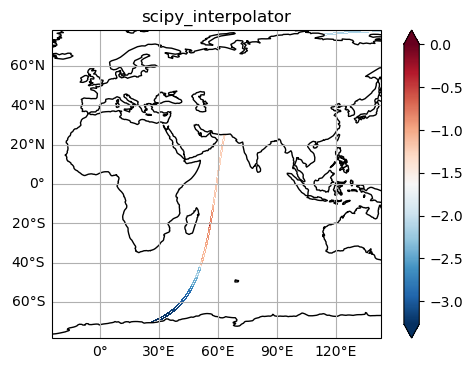

In [10]:
dsi=xr.open_dataset(output_file)
fig_interp(dsi,"ssh")
#plt.xlim(0, 180)
plt.title(interpolator)
#plt.ylim(-70, 10)

In [11]:
%%time
interpolator = "pyinterp_interpolator"
output_file = f"{output_dir}test_{model}_511_002_{interpolator}_{time_step:03d}.nc"

try:
    os.remove(output_file)
except:
    pass

interpolate_modeltoswot(file1=file1,
                        file2=mask_file,
                        file3= swot_grid_file,
                        var_name=var_name,
                        lat_name=lat_name,
                        lon_name=lon_name,
                        time_name=time_name,
                        time_step=time_step,
                        interpolator = interpolator,
                        output_file=output_file,
                       )


Interpolation in progress ...
Output saved to ../interpolated_data/test_eorca_511_002_pyinterp_interpolator_010.nc
CPU times: user 1.29 s, sys: 47.8 ms, total: 1.34 s
Wall time: 1.39 s


Text(0.5, 1.0, 'pyinterp_interpolator')

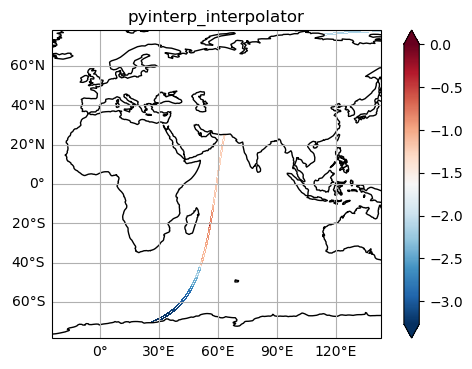

In [12]:
dsi=xr.open_dataset(output_file)
fig_interp(dsi,"ssh")
plt.title(interpolator)